<a href="https://colab.research.google.com/github/lemy198/Hands-on_AI_projects/blob/main/HoangMyLe_Course_Project_2_CA_House_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check GPU is enabled
* To use GPU, go to ``Runtime`` -> ``change runtime type`` -> ``T4 GPU``.

In [ ]:
import torch

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Prepare the Dataset
* We will use the colab default dataset, i.e., ``california_housing_train.csv`` and ``california_housing_test.csv``.
* We start with define a dataset to specify the input and output features.

In [ ]:
from torch.utils.data import Dataset
import pandas as pd

class CAHousingDataset(Dataset):
    def __init__(self, file_location):
        df = pd.read_csv(file_location)

        # uncomment the following two lines if you want to select specific columns.
        input_indices = [2, 3, 4, 6, 8]  # list of input column indices
        input_columns = [df.columns[i] for i in input_indices]
        #input_columns = df.columns[:-1] # all columns except the last one as inputs
        output_column = df.columns[-1]  # target

        # Calculate mean and std for normalization
        input_means = df[input_columns].mean()
        input_stds = df[input_columns].std()
        target_mean = df[output_column].mean()
        target_std = df[output_column].std()

        # Normalize features and target
        self.inputs = torch.tensor(((df[input_columns] - input_means) / input_stds).values, dtype=torch.float32)
        self.targets = torch.tensor(((df[output_column] - target_mean) / target_std).values.reshape(-1, 1),
                                    dtype=torch.float32)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

* Then, we can load the dataset. Here, we will split the ``california_housing_train.csv`` into training and validation dataset.


In [ ]:
from torch.utils.data import DataLoader, random_split

def split_dataset(dataset, train_ratio=0.8):
    """
    Splits the dataset into training and validation sets.

    Parameters:
    - dataset (Dataset): The dataset to split.
    - train_ratio (float): Ratio of training data (default: 0.8).

    Returns:
    - train_dataset, val_dataset: Split datasets.
    """
    total_size = len(dataset)
    train_size = int(train_ratio * total_size)
    val_size = total_size - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    return train_dataset, val_dataset

* Then, we can load the dataset into batches, shuffle it, and prepare it for training.

In [ ]:
def load_data(train_path, test_path):
    dataset = CAHousingDataset(train_path)
    test_dataset = CAHousingDataset(test_path)

    # Split the dataset
    train_dataset, val_dataset = split_dataset(dataset, train_ratio=0.8)

    # Create DataLoaders for training, validation, and testing
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Check the splits
    print(f"Total dataset size: {len(dataset)}")
    print(f"Training set size: {len(train_dataset)}")
    print(f"Validation set size: {len(val_dataset)}")
    print(f"Testing set size: {len(test_dataset)}")

    # Display the first batch in training_dataset
    for batch in train_loader:
        inputs, targets = batch
        print(f"Training Dataset: Input Shape: {inputs.shape} | Output Shape: {targets.shape}")
        break  # Just check one batch

    # Display the first batch in testing_dataset
    for batch in test_loader:
        inputs, targets = batch
        print(f"Testing Dataset: Input Shape: {inputs.shape} | Output Shape: {targets.shape}")
        break  # Just check one batch

    return train_loader, train_dataset, val_loader, val_dataset, test_loader, test_dataset

# Load the dataset
train_path = "/content/sample_data/california_housing_train.csv"
test_path = "/content/sample_data/california_housing_test.csv"

train_loader, train_dataset, val_loader, val_dataset, test_loader, test_dataset = load_data(train_path,test_path)

Total dataset size: 17000
Training set size: 13600
Validation set size: 3400
Testing set size: 3000
Training Dataset: Input Shape: torch.Size([32, 5]) | Output Shape: torch.Size([32, 1])
Testing Dataset: Input Shape: torch.Size([32, 5]) | Output Shape: torch.Size([32, 1])


# Define the Deep Learning Model
* Here, we define a simple feedforward neural network to make the prediction.
* You can edit the model structure, like the number of layers and the value of ``hidden_dim``.

In [ ]:
# Import necessary libraries
import torch.nn as nn

# Define the Neural Network using nn.Sequential
class NeuralNetwork(nn.Module):
    def __init__(self, input_features, output_features, hidden_dim):
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_features, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_features),
        )

    def forward(self, x):
        x = self.model(x)
        return x

# Define the model
model = NeuralNetwork(input_features=len(test_dataset.inputs[0]),
                      output_features=1,
                      hidden_dim=128).to(device)


# Training Loop
* This section defines the training loop.
* We implement a technique, called ``early_stop``.
    * If the model does not improve the loss on the validation dataset for consecutive ``100`` epoches, we stop the training.

Epoch [1/10], Train Loss: 0.0354, Validation Loss: 0.0045
Saving Model with Loss 0.004
Epoch [2/10], Train Loss: 0.0034, Validation Loss: 0.0030
Saving Model with Loss 0.003
Epoch [3/10], Train Loss: 0.0025, Validation Loss: 0.0023
Saving Model with Loss 0.002
Epoch [4/10], Train Loss: 0.0021, Validation Loss: 0.0019
Saving Model with Loss 0.002
Epoch [5/10], Train Loss: 0.0017, Validation Loss: 0.0016
Saving Model with Loss 0.002
Epoch [6/10], Train Loss: 0.0015, Validation Loss: 0.0014
Saving Model with Loss 0.001
Epoch [7/10], Train Loss: 0.0013, Validation Loss: 0.0012
Saving Model with Loss 0.001
Epoch [8/10], Train Loss: 0.0011, Validation Loss: 0.0011
Saving Model with Loss 0.001
Epoch [9/10], Train Loss: 0.0010, Validation Loss: 0.0010
Saving Model with Loss 0.001
Epoch [10/10], Train Loss: 0.0009, Validation Loss: 0.0009
Saving Model with Loss 0.001
Training complete!


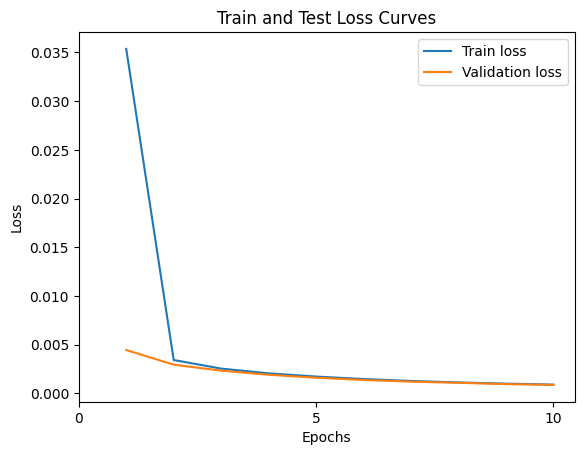

In [ ]:
import torch.optim as optim
import math
import matplotlib.pyplot as plt

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.SGD(model.parameters(), lr=0.005)  # optimizer

epoch_count = []
train_loss_values = []
val_loss_values = []
best_loss = math.inf
early_stop_count = 0

num_epochs = 10
early_stop = 10    # if the model does not improve on validation in 5 epoches, stop the model.

save_path = "/content/FNN.pth"

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0.0  # Track the total loss for this epoch

    for inputs, targets in train_loader:
        # Move inputs and targets to the GPU (if available)
        inputs, targets = inputs.to(device), targets.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass: compute the model output
        output = model(inputs)

        # Compute the loss
        loss = criterion(output, targets)

        # Backward pass: compute the gradients
        loss.backward()

        # Update the weights
        optimizer.step()

        # Accumulate the training loss
        train_loss += loss.item()

    # Calculate average training loss for this epoch
    avg_train_loss = train_loss / len(train_loader)
    train_loss_values.append(avg_train_loss)

    # Evaluate on the validation set
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0  # Track total test loss for this epoch

    with torch.inference_mode():  # No gradients needed
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    # Calculate average validation loss for this epoch
    avg_val_loss = val_loss / len(val_loader)
    val_loss_values.append(avg_val_loss)

    # Store the epoch number
    epoch_count.append(epoch + 1)

    # Print the average losses for this epoch
    print(
        f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    # If the test results on validation data is better than the history, save the model
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), save_path)
        print(f'Saving Model with Loss {best_loss:.3f}')
        early_stop_count = 0
    else:
        early_stop_count += 1

    # If the model does not improve for a certain amount of times, break the training loop
    if early_stop_count >= early_stop:
        print('\nModel is not improving, stop the training')
        break

print("Training complete!")

# Complete the training and plot the training result
# Plot train and test loss values
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, val_loss_values, label="Validation loss")
plt.title("Train and Test Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Set x-ticks to show integers only
plt.xticks(ticks=[0, len(epoch_count) / 2, len(epoch_count)])

plt.show()

# Evaluation
* Evaluate the model performance on the testing dataset.
* We will also generate a parity plot to show the prediction results.

MSE Loss for FNN is: 0.0009316130308434367 | R2 Score is: 0.9990680813789368


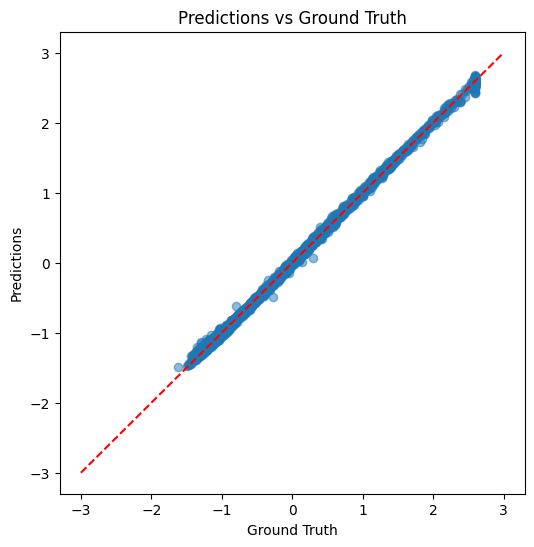

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

# load the model
model_path = "/content/FNN.pth"

model.eval()  # Set the model to evaluation mode

predictions = []
ground_truths = []
loss = 0.0
criterion = nn.MSELoss()
# No gradient calculation during testing
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss += criterion(outputs, targets)
        predictions.append(outputs)
        ground_truths.append(targets)

# Combine all batches into single tensors
predictions = torch.cat(predictions, dim=0).cpu().numpy()
ground_truths = torch.cat(ground_truths, dim=0).cpu().numpy()

r2 = r2_score(ground_truths, predictions)
mse = mean_squared_error(ground_truths, predictions)

print(f"MSE Loss for FNN is: {mse} | R2 Score is: {r2}")

# Scatter plot of ground truth vs. predictions
plt.figure(figsize=(6, 6))
plt.scatter(ground_truths, predictions, alpha=0.5)
plt.plot([-3, 3], [-3, 3], 'r', linestyle='--')  # 45-degree reference line
plt.xlabel("Ground Truth")
plt.ylabel("Predictions")
plt.title("Predictions vs Ground Truth")
plt.show()